This notebook contains a deeper exploration of our fiducial model, including the full evolution with each radius at each timestep

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
import pandas as pd
import vice
import seaborn as sns

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import surp
from surp import gce_math as gcem
from surp.yields import calc_y
import arya

In [4]:
#model_dir = "../models/C11_piecelin/"
model_dir = "../models/fiducial/run"

In [5]:
fiducial = surp.ViceModel.from_file(model_dir + "/model.json")

In [6]:
yp = surp.yields.YieldParams.from_file(model_dir + "/yield_params.toml")
surp.yields.set_yields(yp)

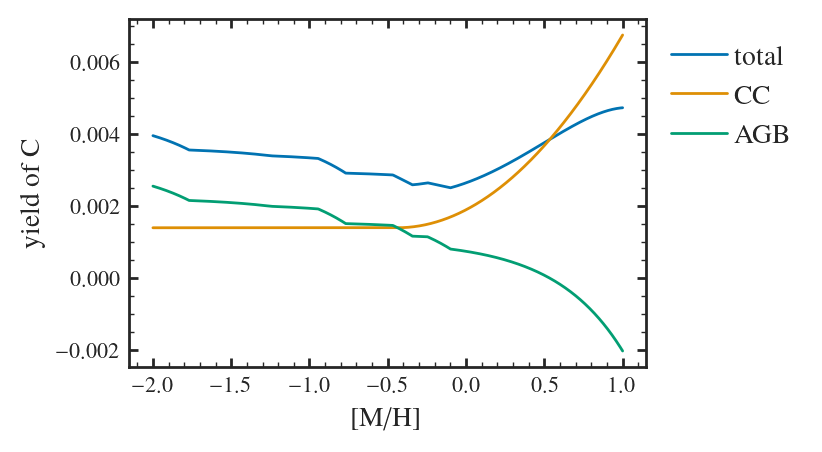

In [7]:
MH = np.linspace(-2, 1, 1000)
Z = gcem.MH_to_Z(MH)
y = calc_y(Z, kind="all")
plt.plot(MH, y, label="total")
y = calc_y(Z, kind="cc")
plt.plot(MH, y, label="CC")

y = calc_y(Z, kind="agb")
plt.plot(MH, y, label="AGB")
plt.xlabel("[M/H]")
plt.ylabel("yield of C")
arya.Legend(-1)

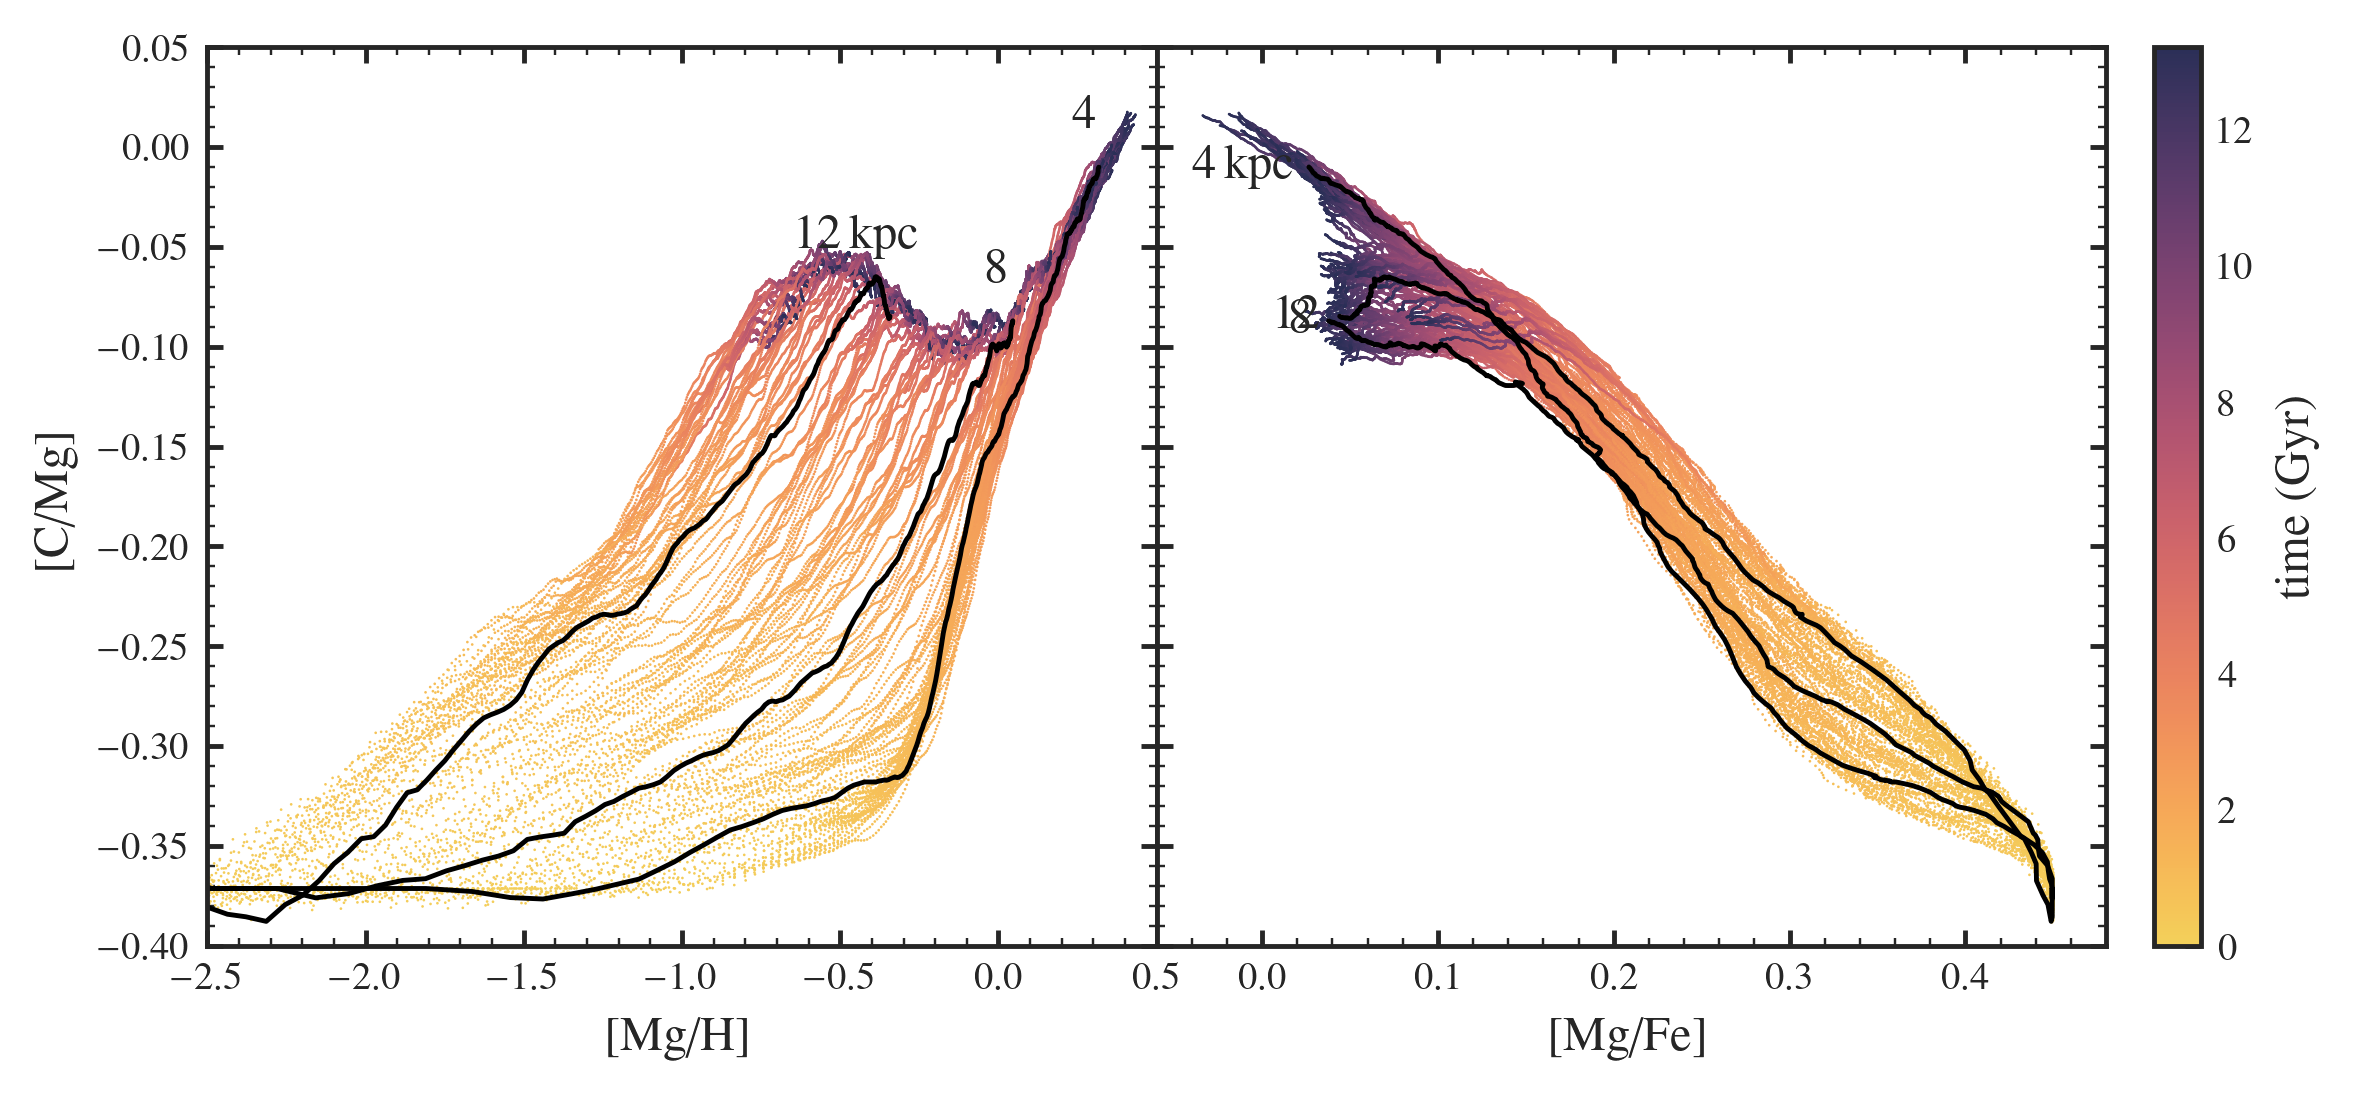

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3), dpi=350)

plt.sca(axs[0])
h = fiducial.history

coords = []

for R in [4,8, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df.MG_H, df.C_MG, color="k")
    coords.append((
            df.MG_H.iloc[-1], 
            df.C_MG.iloc[-1]
        ))


texts = [
    "4",
    #"6",
    "8",
    #"10",
    r"12\,kpc"
]

for i in range(len(coords)):
    if i >= 2:
        offset = (-6, 12)
    else:
        offset = (-3, 6)
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="center", va="bottom",  
                        xycoords='data', textcoords='offset points', xytext=offset)

sns.scatterplot(h[(h.R > 1) & (h.R < 15.5)], x="MG_H", y="C_MG", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-2.5, 0.5)
#plt.ylim(-0.45, 0.05)
#surp.plots.plot_annulus_at_t(fiducial, "MG_H", "C_MG", t=2, zorder=-2)



plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.sca(axs[1])



filt = fiducial.history["MG_H"] > -0.15
filt &= fiducial.history["MG_H"] < -0.05
h = fiducial.history

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

cb = arya.Colorbar(clim=(0, 13.2), label=r"time (Gyr)", cmap="arya_r", cax=cax)


label_Rs = [4,8,12]
coords = []

for R in np.sort(h.R.unique()):
    if (R < 1) or (R > 15.5):
        continue
        
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    plt.scatter(dfa.O_FE, dfa.C_O, c=cb(dfa.time), s=0.3, ec="none", rasterized=True, zorder=1)
    if any(np.isclose(R+0.05, label_Rs)):
        coords.append((
            dfa["MG_FE"].iloc[-1], 
            dfa["C_MG"].iloc[-1]
        ))

        plt.plot(dfa["MG_FE"], dfa["C_MG"], color="k", zorder=2, lw=1)
    

texts = [
    "4\\,kpc",
   #"6",
    "8",
    #"10",
    r"12"
]


for i in range(len(coords)):
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="right",  va="center",
                        xycoords='data', textcoords='offset points', xytext=(-3, 0))
#     text.set_path_effects([mpl.patheffects.Stroke(linewidth=5, foreground='w'),
#                    mpl.patheffects.Normal()])
    
plt.xlim(-0.06, 0.48)
plt.ylim(-0.40, 0.05)
plt.xlabel("[Mg/Fe]")



plt.savefig("figures/all_the_tracks.pdf")

## Quick checks

In [9]:
label_Rs

[4, 8, 12]

Text(0, 0.5, '[C/Mg]')

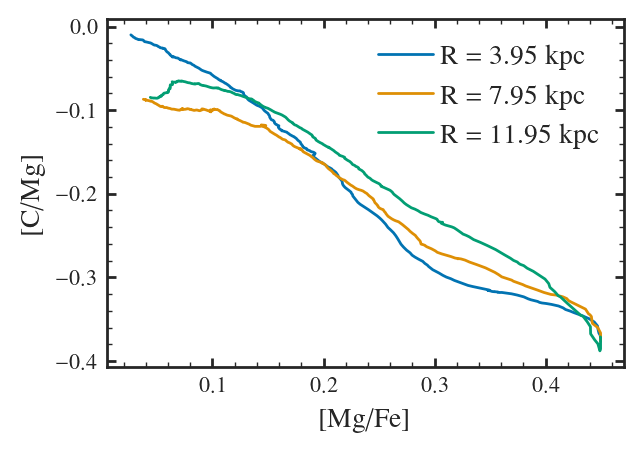

In [10]:
for R in np.sort(np.sort(h.R.unique())):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    if any(np.isclose(R+0.05, label_Rs)):
        coords.append((
            dfa["MG_FE"].iloc[-1], 
            dfa["C_MG"].iloc[-1]
        ))

        plt.plot(dfa["MG_FE"], dfa["C_MG"], label=f"R = {R:0.2f} kpc", zorder=2, lw=1)

plt.legend()
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

In [11]:
filt = fiducial.history.time == 13.2
filt &= fiducial.history.R > 7
filt &= fiducial.history.R <= 9


In [12]:
sum(fiducial.history.mstar[filt])

5066846100.0

Text(0, 0.5, '[C/Mg]')

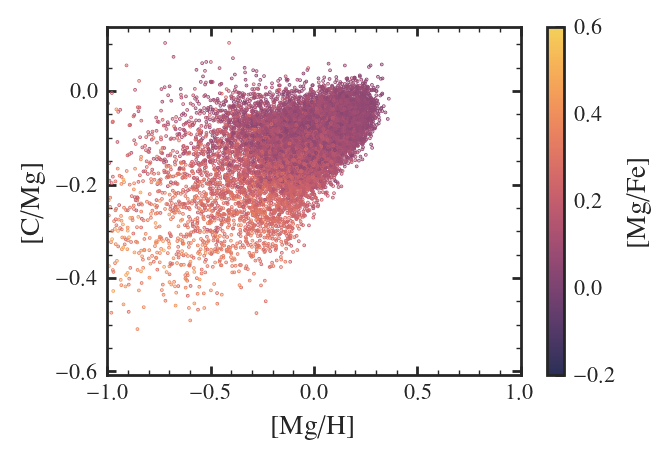

In [13]:
plt.scatter(fiducial.stars.MG_H, fiducial.stars.C_MG, s=0.1, c=fiducial.stars.MG_FE, vmin=-0.2, vmax=0.6)
plt.xlim(-1, 1)
#plt.ylim(-1, 1)
plt.colorbar(label="[Mg/Fe]")
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [14]:
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', arya.COLORS, len(arya.COLORS))

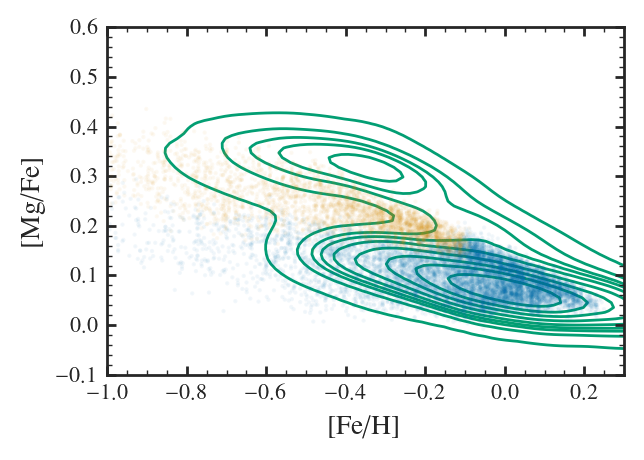

In [15]:
# define the bins and normalize
bounds = np.arange(0, len(arya.COLORS))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(fiducial.stars.FE_H, fiducial.stars.MG_FE, s=0.3, alpha=0.05, c=fiducial.stars.high_alpha, cmap=cmap, norm=norm)




plt.xlim(-1, 0.3)
plt.ylim(-0.1, 0.6)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")

x = np.linspace(-1, 0.3, 1000)
y = surp.gce_math.mg_fe_cutoff(x)
#plt.plot(x, y, color="k")

sns.kdeplot(surp.subgiants, x="FE_H", y="MG_FE", zorder=-1, color=arya.COLORS[2]);



In [16]:
s = fiducial.stars

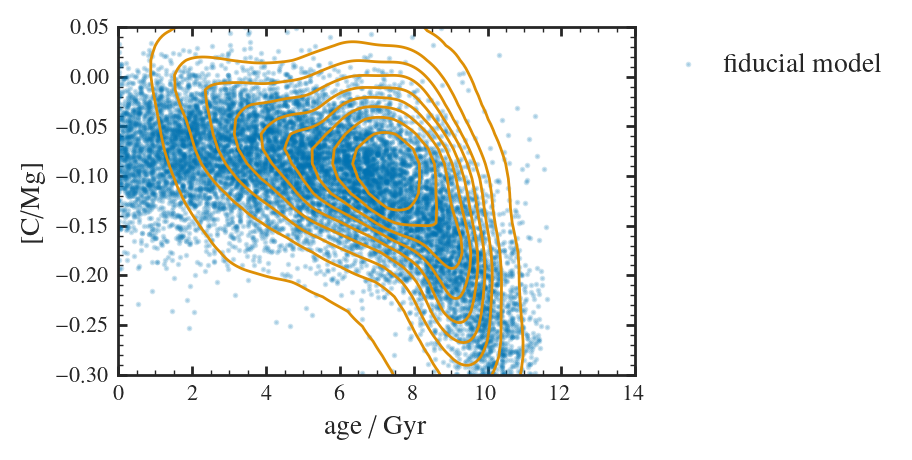

In [17]:
age_shift = 1.5

plt.scatter(s.age - age_shift, s.C_MG, s=1, alpha=0.2, label="fiducial model")
sns.kdeplot(surp.subgiants, x="age_ANN", y="C_MG", zorder=1, color=arya.COLORS[1], label="ANN ages");
plt.xlabel("age / Gyr")
plt.ylabel("[C/Mg]")
plt.xlim(0, 14)
plt.ylim(-0.3, 0.05)
arya.Legend(-1)

# Other properties
Here, I want to make plots of the AGB Fraction across the galaxy.

Text(0, 0.5, 'count')

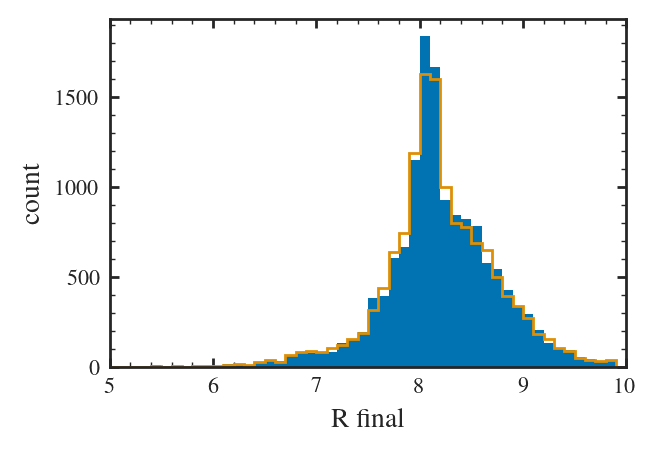

In [18]:
plt.hist(fiducial.stars.r_final, bins=np.arange(4, 10, 0.1),);
plt.hist(surp.subgiants.R_gal, bins=np.arange(4, 10, 0.1), histtype="step")
plt.xlim(5, 10)
plt.xlabel("R final")
plt.ylabel("count")

Text(0, 0.5, 'count')

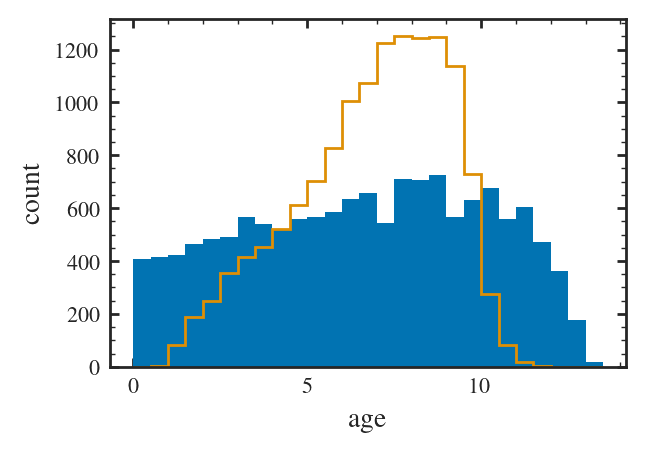

In [19]:
plt.hist(fiducial.stars.age, bins=np.arange(0, 14, 0.5),);
plt.hist(surp.subgiants.age_ANN, bins=np.arange(0, 14, 0.5), histtype="step")
plt.xlabel("age")
plt.ylabel("count")

Text(0, 0.5, '[M/H]')

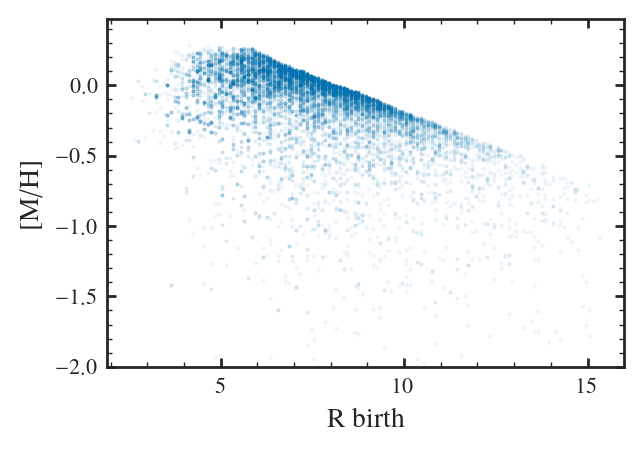

In [20]:
plt.scatter(fiducial.stars.r_origin, fiducial.stars.M_H, s=0.1, alpha=0.1)
plt.ylim(-2)
plt.xlabel("R birth")
plt.ylabel("[M/H]")

## AGB fraction

In [21]:
R_max = 15.5

h = fiducial.history[fiducial.history.R < R_max]
h = h.sort_values(["zone", "time"])

R = np.sort(np.unique(h.R))
t = np.sort(np.unique(h.time))

m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Mc = h["mass(c)"] # Msun

Zc = Mc / h["mgas"]
dt = np.mean(np.diff(t)) # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

y_cc = vice.yields.ccsne.settings["c"]
yc_cc = np.vectorize(y_cc)(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (len(R), len(t)))

In [22]:
max(f_agb[f_agb < 0.5])

np.float64(0.4999898523630893)

In [23]:
Xx = np.reshape(h.zone, (len(R), len(t)))
np.transpose(Xx)[-1, :]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154])

Text(0, 0.5, 'f agb')

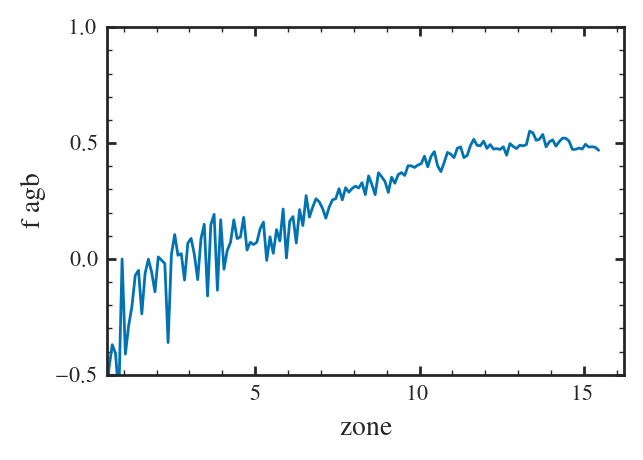

In [24]:
plt.plot(R, np.transpose(X)[-1,:])
plt.ylim(-0.5, 1)
plt.xlim(0.5)
plt.xlabel("zone")
plt.ylabel("f agb")

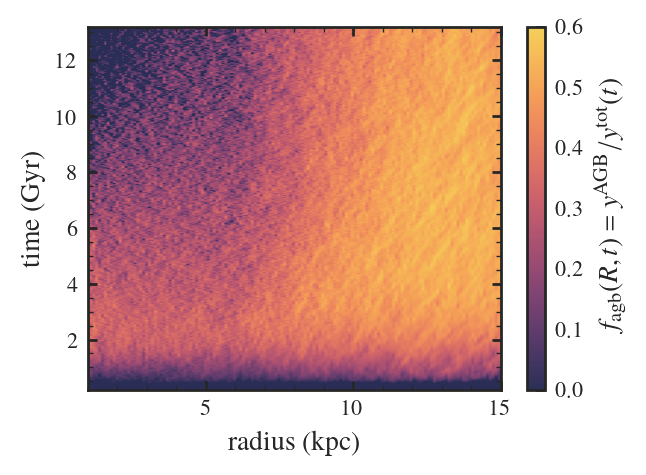

In [25]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
plt.imshow(np.transpose(X)[::-1], clim=(0, 0.6), extent=(np.min(R), np.max(R), np.min(t), np.max(t)), aspect="auto")
plt.xlim(1, 15)
plt.ylim(smooth*dt)

plt.colorbar(label=r"$f_{\rm agb}(R, t) = y^{\rm AGB} / y^{\rm tot} (t)$")
plt.xlabel("radius (kpc)")
plt.ylabel("time (Gyr)")

plt.savefig("figures/f_agb_rt.pdf")

## other chemistry plots & the bimodality

Text(0, 0.5, '[N/Mg]')

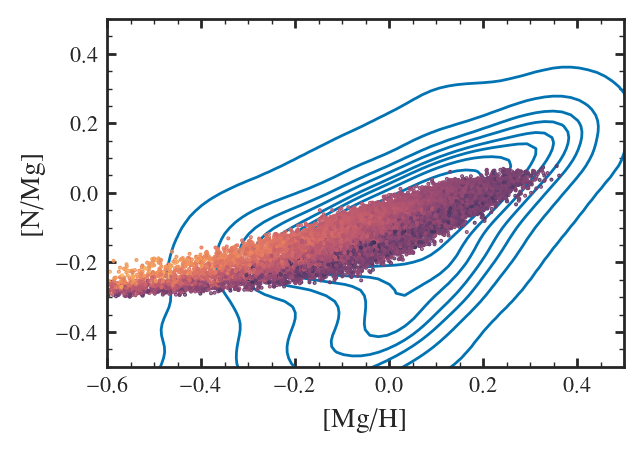

In [26]:
s = fiducial.stars

sns.kdeplot(surp.subgiants[~np.isnan(surp.subgiants.N_MG)], x="MG_H", y="N_MG")
plt.scatter(s["MG_H"], s["N_MG"], 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel("[Mg/H]")
plt.ylabel("[N/Mg]")


The plots below illustrate a possible alternative setup, where we instead show the median 

(-0.6, 0.1)

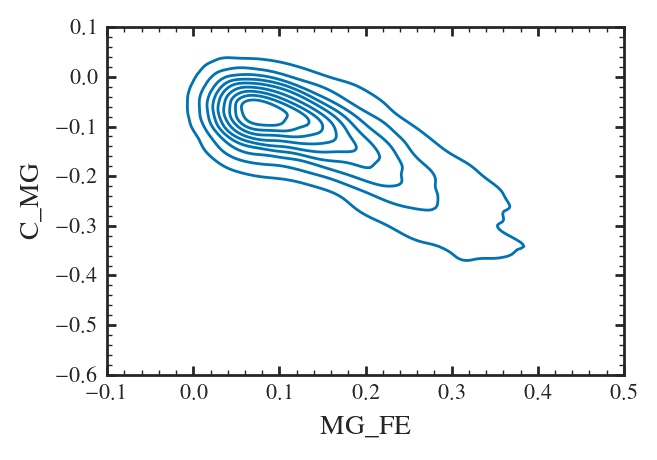

In [27]:
sns.kdeplot(s, x="MG_FE", y="C_MG");
plt.xlim(-0.1, 0.5)
plt.ylim(-0.6, 0.1)

(-0.1, 0.5)

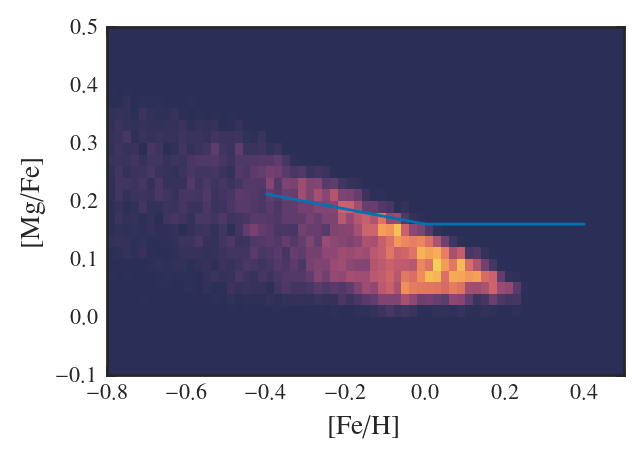

In [28]:
plt.hist2d(fiducial.stars.FE_H, fiducial.stars.MG_FE, range=((-1, 1),( -1, 1)), bins=100 )
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
x = np.linspace(-0.4, 0.4)
y = gcem.mg_fe_cutoff(x)
plt.plot(x, y)
plt.xlim(-0.8, 0.5)
plt.ylim(-0.1, 0.5)

Text(0.5, 1.0, 'subgiants')

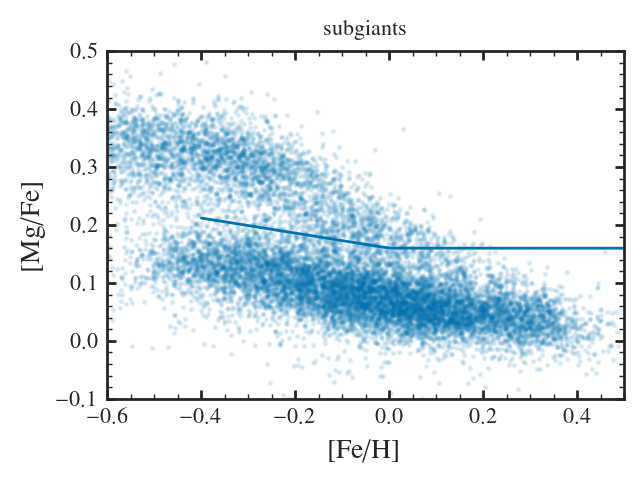

In [29]:
plt.scatter(surp.subgiants.FE_H, surp.subgiants.MG_FE, s=1, alpha=0.1)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
x = np.linspace(-0.4, 0.5)
y = gcem.mg_fe_cutoff(x)
plt.plot(x, y)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.1, 0.5)
plt.title("subgiants")

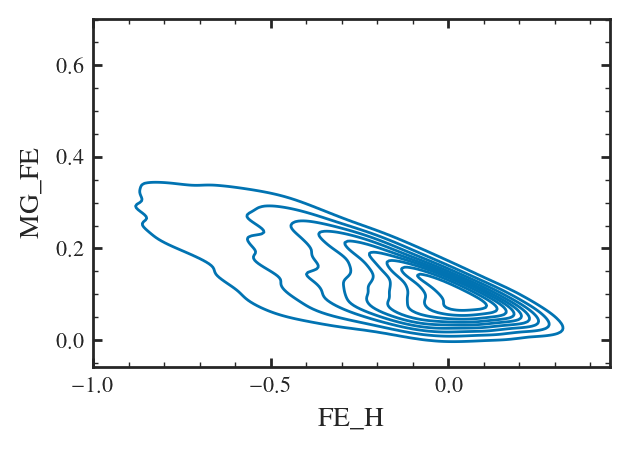

In [30]:
sns.kdeplot(fiducial.stars, x="FE_H", y="MG_FE", clip=((-1, 1), (-1, 1)));

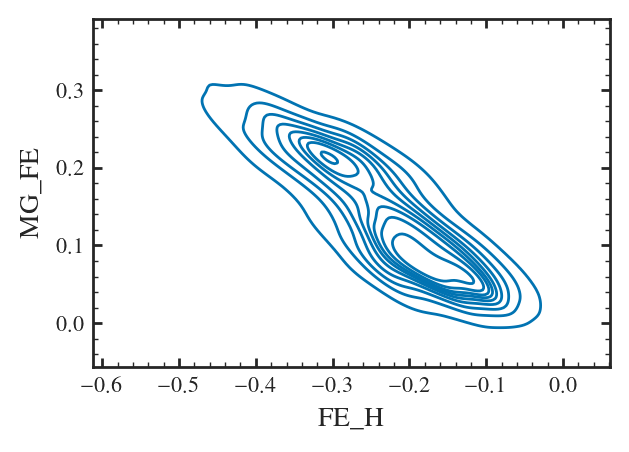

In [31]:
sns.kdeplot(surp.filter_metallicity(s), x="FE_H", y="MG_FE");

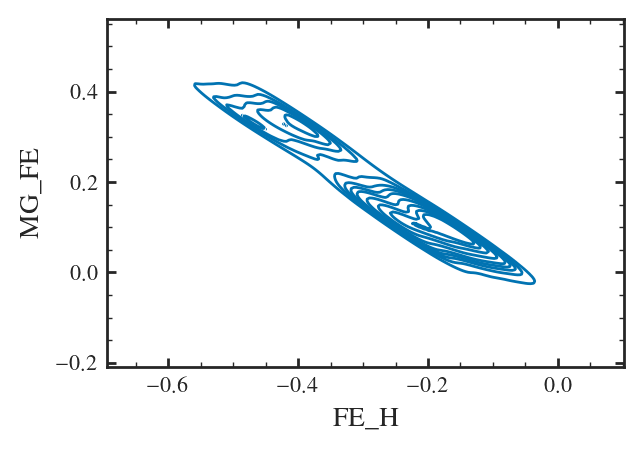

In [32]:
sns.kdeplot(surp.filter_metallicity(surp.subgiants), x="FE_H", y="MG_FE");

In [33]:
sns.kdeplot(surp.plots.filter_metallicity(s), x="MG_FE", y="C_MG");

AttributeError: module 'surp' has no attribute 'plots'

In [ ]:
sns.scatterplot(surp.filter_metallicity(s), x="MG_FE_true", y="C_MG_true", alpha=0.2);

In [ ]:
sns.scatterplot(surp.filter_metallicity(s), x="MG_FE", y="C_MG", alpha=0.2);

In [ ]:
#sns.scatterplot(surp.plots.filter_metallicity(s), x="MG_FE", y="C_MG", alpha=0.2);
sns.kdeplot(surp.filter_metallicity(surp.subgiants), x="MG_FE", y="C_MG",)

## Understanding Mg/Fe | Mg/H

In [ ]:
h = fiducial.history


sns.scatterplot(h[(h.R > 2) & (h.R < 15.5)], x="MG_H", y="MG_FE", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-2.5, 0.5)
#plt.ylim(-0.45, 0.05)
#surp.plots.plot_annulus_at_t(fiducial, "MG_H", "C_MG", t=2, zorder=-2)
plt.axvline(-0.1)


The plot below shows the region in parameterspace our selection in metallicity chooses.
Because the inner galaxy evolution is fairly homogenous, these regions reach \[M/H\] ~ -0.1 quickly and with a \[Mg/Fe\] on the plateau. However, at higher radii, the time to reach this metallicity takes longer and so SNeIa have time to decrease the \[Mg/Fe\] ratio, so the metallicity selection keeps stars with lower alpha/Fe abundances and born later in the galaxy. As such, \[Mg/Fe\] becomes a proxy for time when selected by metallicity, so the C-Mg/Mg-Fe trend should approximate SSP evolution in C/Mg with time.

In [ ]:
filt = (h.R > 2) & (h.R < 15.5)
filt &= h.MG_H > -0.15
filt &= h.MG_H < -0.05

sns.scatterplot(h[filt], x="R", y="MG_FE", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)


In [ ]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), ax=plt.gca(), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    df = surp.filter_metallicity(s, c=MH, w=0.05)

    Cm = np.median(df.C_MG[~df.high_alpha])

    df["C_Cm"] = df.C_MG - Cm

    #plt.scatter(0, Cm, color=cb(MH))
    N = len(df)
    Npb = 10 * round(N**(2/5))
    print(Npb)
    
    arya.medianplot(df, x="MG_FE", y="C_Cm", binsize=Npb, color=cb(MH), aes="scatter", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/median C]")


In [ ]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), ax=plt.gca(), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    df = surp.filter_metallicity(s, c=MH)
    N = len(df)
    Npb = 10 * round(N**(2/5))
    print(Npb)
    
    arya.medianplot(df, x="MG_FE", y="C_MG", binsize=Npb, color=cb(MH), aes="scatter", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/fiducial_caafe_binned.pdf")